In [1]:
import pandas as pd
import numpy as np
import os
import json
import itertools as it
import time
import subprocess
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from datetime import date, datetime, timedelta
from tensorflow import keras
from keras.layers import LSTM, SimpleRNN, GRU
from sklearn.metrics import confusion_matrix,classification_report,ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, average_precision_score
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from keras.utils import plot_model
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

2024-04-13 14:34:22.372891: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-13 14:34:22.403610: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-13 14:34:22.946612: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
majestic = pd.read_csv('./treino/majestic_ascii.csv')
majestic['69'] = 0
majestic['70'] = 0
majestic['71'] = 0
majestic

,domain,label,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
0,google.com,0,103,111,111,103,108,101,46,99,...,0,0,0,0,0,0,0,0,0,0
1,facebook.com,0,102,97,99,101,98,111,111,107,...,0,0,0,0,0,0,0,0,0,0
2,youtube.com,0,121,111,117,116,117,98,101,46,...,0,0,0,0,0,0,0,0,0,0
3,twitter.com,0,116,119,105,116,116,101,114,46,...,0,0,0,0,0,0,0,0,0,0
4,instagram.com,0,105,110,115,116,97,103,114,97,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,fidgit.com,0,102,105,100,103,105,116,46,99,...,0,0,0,0,0,0,0,0,0,0
999996,fixwindows10connections.com,0,102,105,120,119,105,110,100,111,...,0,0,0,0,0,0,0,0,0,0
999997,flyerguide.com,0,102,108,121,101,114,103,117,105,...,0,0,0,0,0,0,0,0,0,0
999998,forwardpathway.com,0,102,111,114,119,97,114,100,112,...,0,0,0,0,0,0,0,0,0,0


In [3]:
dga = pd.read_csv('./treino/df_train.csv')
dga = dga.drop('family', axis = 1)
dga

,domain,label,3,4,5,6,7,8,9,10,...,63,64,65,66,67,68,69,70,71,72
0,uzwdmrlhr.tk,1,117,122,119,100,109,114,108,104,...,0,0,0,0,0,0,0,0,0,0
1,uzwdmrlhr.com,1,117,122,119,100,109,114,108,104,...,0,0,0,0,0,0,0,0,0,0
2,uzwdmrlhr.pages.dev,1,117,122,119,100,109,114,108,104,...,0,0,0,0,0,0,0,0,0,0
3,rhrlwdumz.tk,1,114,104,114,108,119,100,117,109,...,0,0,0,0,0,0,0,0,0,0
4,rhrlwdumz.com,1,114,104,114,108,119,100,117,109,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1352254,kwgjjpbcaaanbivklyxx.com,1,107,119,103,106,106,112,98,99,...,0,0,0,0,0,0,0,0,0,0
1352255,vxijfvgvihjnfvofxmyc.com,1,118,120,105,106,102,118,103,118,...,0,0,0,0,0,0,0,0,0,0
1352256,cepswmbgtknhtkhlsecg.com,1,99,101,112,115,119,109,98,103,...,0,0,0,0,0,0,0,0,0,0
1352257,tifjhjtouqmdlbkfnuow.com,1,116,105,102,106,104,106,116,111,...,0,0,0,0,0,0,0,0,0,0


In [4]:
dga.columns = majestic.columns

In [5]:
dga = dga.loc[~dga['domain'].isin(majestic['domain'])].reset_index(drop=True)

In [6]:
dga = pd.concat([majestic,dga], axis = 0, ignore_index=True)

In [7]:
df_train,df_test = train_test_split(dga, test_size=0.3, random_state=11, shuffle=True)

In [8]:
df_train.groupby('label').count()

,domain,2,3,4,5,6,7,8,9,10,...,62,63,64,65,66,67,68,69,70,71
label,,,,,,,,,,,,,,,,,,,,,
0,700327,700327,700327,700327,700327,700327,700327,700327,700327,700327,...,700327,700327,700327,700327,700327,700327,700327,700327,700327,700327
1,946217,946217,946217,946217,946217,946217,946217,946217,946217,946217,...,946217,946217,946217,946217,946217,946217,946217,946217,946217,946217


In [9]:
df_test.groupby('label').count()

,domain,2,3,4,5,6,7,8,9,10,...,62,63,64,65,66,67,68,69,70,71
label,,,,,,,,,,,,,,,,,,,,,
0,299673,299673,299673,299673,299673,299673,299673,299673,299673,299673,...,299673,299673,299673,299673,299673,299673,299673,299673,299673,299673
1,405990,405990,405990,405990,405990,405990,405990,405990,405990,405990,...,405990,405990,405990,405990,405990,405990,405990,405990,405990,405990


In [10]:
X_train = df_train.drop(['domain','label'], axis = 1)
y_train = df_train['label']

X_test = df_test.drop(['domain','label'], axis = 1)
y_test = df_test['label']

In [11]:
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

In [12]:
X_train.shape, X_test.shape

((1646544, 70), (705663, 70))

In [13]:
#Carregando hyperparâmetros de regularizadores, otimizador e função de ativação
l1l2 = keras.regularizers.l1_l2(l1=0.00001, l2=0.0001)
opt = keras.optimizers.Adam(learning_rate=0.0001)
fx = "relu"

2024-04-10 18:05:54.330609: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-10 18:05:54.378222: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-10 18:05:54.378388: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

## Modelo 1

In [14]:
#Estrutura do modelo convolucional profundo
model_1 = tf.keras.Sequential([
      
        layers.Embedding(input_dim=256,output_dim=60,input_length=70),
    
        layers.Conv1D(500, 7, activation=fx, activity_regularizer=l1l2, padding='same'),
        layers.ReLU(),
            
        layers.Conv1D(250, 6, activation=fx, activity_regularizer=l1l2, padding='same'),
        layers.ReLU(),
        layers.MaxPooling1D(pool_size=6, strides=1, padding='same'),
    
        layers.Conv1D(120, 5, activation=fx, activity_regularizer=l1l2, padding='same'),
        layers.ReLU(),
    
        layers.Conv1D(60, 5, activation=fx, activity_regularizer=l1l2, padding='same'),
        layers.ReLU(),
        layers.MaxPooling1D(pool_size=4, strides=1, padding='same'),
    
        layers.Conv1D(30, 4, activation=fx, activity_regularizer=l1l2, padding='same'),
        layers.ReLU(),
    
        layers.Conv1D(30, 3, activation=fx, activity_regularizer=l1l2, padding='same'),
        layers.ReLU(),
        layers.MaxPooling1D(pool_size=3, strides=1, padding='same'),
    
        layers.Flatten(),
        layers.Dense(15, activation=fx, activity_regularizer=l1l2),
        layers.Dense(1, activation='sigmoid')])

model_1.compile(optimizer = opt, loss = 'binary_crossentropy', metrics='accuracy')
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 70, 60)            15360     
                                                                 
 conv1d (Conv1D)             (None, 70, 500)           210500    
                                                                 
 re_lu (ReLU)                (None, 70, 500)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 70, 250)           750250    
                                                                 
 re_lu_1 (ReLU)              (None, 70, 250)           0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 70, 250)           0         
 D)                                                              
                                                        

In [15]:
best1 = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model12',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [13]:
# Ajustando uso de memoria RAM e GPU
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  pass

2024-04-10 15:52:54.710629: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-10 15:52:54.754662: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-10 15:52:54.754815: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [18]:
model_1.fit(X_train, y_train,
              epochs=10,
              validation_split = 0.1,
              callbacks = [best1],
              batch_size=200)

Epoch 1/10


2024-04-10 14:39:50.520159: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8902
2024-04-10 14:39:51.165245: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-04-10 14:39:51.167431: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x59492dd88550 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-10 14:39:51.167445: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-04-10 14:39:51.171646: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-10 14:39:51.251576: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifeti

7410/7410 [==============================] - ETA: 0s - loss: 0.1099 - accuracy: 0.9608

2024-04-10 14:44:34.124860: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.73GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-10 14:44:34.130372: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.73GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


INFO:tensorflow:Assets written to: best_model12/assets


INFO:tensorflow:Assets written to: best_model12/assets


7410/7410 [==============================] - 296s 39ms/step - loss: 0.1099 - accuracy: 0.9608 - val_loss: 0.0886 - val_accuracy: 0.9697
Epoch 2/10
7409/7410 [============================>.] - ETA: 0s - loss: 0.0637 - accuracy: 0.9784INFO:tensorflow:Assets written to: best_model12/assets


INFO:tensorflow:Assets written to: best_model12/assets


7410/7410 [==============================] - 287s 39ms/step - loss: 0.0637 - accuracy: 0.9784 - val_loss: 0.0640 - val_accuracy: 0.9782
Epoch 3/10
7409/7410 [============================>.] - ETA: 0s - loss: 0.0517 - accuracy: 0.9826INFO:tensorflow:Assets written to: best_model12/assets


INFO:tensorflow:Assets written to: best_model12/assets


7410/7410 [==============================] - 288s 39ms/step - loss: 0.0517 - accuracy: 0.9826 - val_loss: 0.0613 - val_accuracy: 0.9789
Epoch 4/10
7409/7410 [============================>.] - ETA: 0s - loss: 0.0433 - accuracy: 0.9856INFO:tensorflow:Assets written to: best_model12/assets


INFO:tensorflow:Assets written to: best_model12/assets


7410/7410 [==============================] - 288s 39ms/step - loss: 0.0433 - accuracy: 0.9856 - val_loss: 0.0616 - val_accuracy: 0.9790
Epoch 5/10
7409/7410 [============================>.] - ETA: 0s - loss: 0.0367 - accuracy: 0.9879INFO:tensorflow:Assets written to: best_model12/assets


INFO:tensorflow:Assets written to: best_model12/assets


7410/7410 [==============================] - 287s 39ms/step - loss: 0.0367 - accuracy: 0.9879 - val_loss: 0.0601 - val_accuracy: 0.9801
Epoch 6/10
7410/7410 [==============================] - 288s 39ms/step - loss: 0.0313 - accuracy: 0.9897 - val_loss: 0.0624 - val_accuracy: 0.9799
Epoch 7/10
7410/7410 [==============================] - 287s 39ms/step - loss: 0.0268 - accuracy: 0.9913 - val_loss: 0.0649 - val_accuracy: 0.9799
Epoch 8/10
7410/7410 [==============================] - 287s 39ms/step - loss: 0.0229 - accuracy: 0.9928 - val_loss: 0.0699 - val_accuracy: 0.9786
Epoch 9/10
7410/7410 [==============================] - 287s 39ms/step - loss: 0.0197 - accuracy: 0.9939 - val_loss: 0.0734 - val_accuracy: 0.9796
Epoch 10/10
7410/7410 [==============================] - 287s 39ms/step - loss: 0.0170 - accuracy: 0.9948 - val_loss: 0.0750 - val_accuracy: 0.9781


In [21]:
model_1 = tf.keras.models.load_model('best_model12')

In [22]:
predictions = model_1.predict(X_test)
predictions = np.where(predictions > 0.5, 1, 0)

print('Matriz de Confusão')
print(confusion_matrix(y_test,predictions))

print('Relatório de Classificação')
print(classification_report(y_test,predictions, digits=4))

22052/22052 [==============================] - 46s 2ms/step
Matriz de Confusão
[[292626   7047]
 [  7047 398943]]
Relatório de Classificação
              precision    recall  f1-score   support

           0     0.9765    0.9765    0.9765    299673
           1     0.9826    0.9826    0.9826    405990

    accuracy                         0.9800    705663
   macro avg     0.9796    0.9796    0.9796    705663
weighted avg     0.9800    0.9800    0.9800    705663



## Modelo 2

In [14]:
#Carregando hyperparâmetros de regularizadores, otimizador e função de ativação
l1l2 = keras.regularizers.l1_l2(l1=0.00001, l2=0.0001)
opt = keras.optimizers.Adam(learning_rate=0.0001)
fx = "relu"

#Estrutura do modelo convolucional profundo
model_2 = tf.keras.Sequential([
      
        layers.Embedding(input_dim=256,output_dim=60,input_length=70),
    
        layers.Conv1D(500, 7, activation=fx, activity_regularizer=l1l2, padding='same'),
        #layers.ReLU(),
            
        layers.Conv1D(250, 6, activation=fx, activity_regularizer=l1l2, padding='same'),
        #layers.ReLU(),
        #layers.MaxPooling1D(pool_size=6, strides=1, padding='same'),
    
        layers.Conv1D(120, 5, activation=fx, activity_regularizer=l1l2, padding='same'),
        #layers.ReLU(),
    
        layers.Conv1D(60, 5, activation=fx, activity_regularizer=l1l2, padding='same'),
        #layers.ReLU(),
        #layers.MaxPooling1D(pool_size=4, strides=1, padding='same'),
    
        layers.Conv1D(30, 4, activation=fx, activity_regularizer=l1l2, padding='same'),
        #layers.ReLU(),
    
        layers.Conv1D(30, 3, activation=fx, activity_regularizer=l1l2, padding='same'),
        #layers.ReLU(),
        #layers.MaxPooling1D(pool_size=3, strides=1, padding='same'),
    
        layers.Flatten(),
        layers.Dense(15, activation=fx, activity_regularizer=l1l2),
        layers.Dense(1, activation='sigmoid')])

model_2.compile(optimizer = opt, loss = 'binary_crossentropy', metrics='accuracy')
model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 70, 60)            15360     
                                                                 
 conv1d (Conv1D)             (None, 70, 500)           210500    
                                                                 
 conv1d_1 (Conv1D)           (None, 70, 250)           750250    
                                                                 
 conv1d_2 (Conv1D)           (None, 70, 120)           150120    
                                                                 
 conv1d_3 (Conv1D)           (None, 70, 60)            36060     
                                                                 
 conv1d_4 (Conv1D)           (None, 70, 30)            7230      
                                                                 
 conv1d_5 (Conv1D)           (None, 70, 30)            2

2024-04-10 15:52:58.746243: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-10 15:52:58.746548: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-10 15:52:58.746696: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [15]:
best2 = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model22',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [16]:
model_2.fit(X_train, y_train,
              epochs=10,
              validation_split = 0.1,
              callbacks = [best2],
              batch_size=200)

Epoch 1/10


2024-04-10 15:53:07.100087: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8902
2024-04-10 15:53:07.743220: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-04-10 15:53:07.745486: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x590890ea6b20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-10 15:53:07.745501: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-04-10 15:53:07.749354: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-10 15:53:07.830502: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifeti

7410/7410 [==============================] - ETA: 0s - loss: 0.1154 - accuracy: 0.9588

2024-04-10 15:57:21.324409: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.73GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-10 15:57:21.330031: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.73GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-10 15:57:21.372291: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 895.20MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-10 15:57:21.377571: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (G

INFO:tensorflow:Assets written to: best_model22/assets


INFO:tensorflow:Assets written to: best_model22/assets


7410/7410 [==============================] - 265s 35ms/step - loss: 0.1154 - accuracy: 0.9588 - val_loss: 0.0778 - val_accuracy: 0.9734
Epoch 2/10
7410/7410 [==============================] - ETA: 0s - loss: 0.0682 - accuracy: 0.9766INFO:tensorflow:Assets written to: best_model22/assets


INFO:tensorflow:Assets written to: best_model22/assets


7410/7410 [==============================] - 256s 35ms/step - loss: 0.0682 - accuracy: 0.9766 - val_loss: 0.0662 - val_accuracy: 0.9773
Epoch 3/10
7409/7410 [============================>.] - ETA: 0s - loss: 0.0551 - accuracy: 0.9812INFO:tensorflow:Assets written to: best_model22/assets


INFO:tensorflow:Assets written to: best_model22/assets


7410/7410 [==============================] - 256s 35ms/step - loss: 0.0551 - accuracy: 0.9812 - val_loss: 0.0627 - val_accuracy: 0.9782
Epoch 4/10
7409/7410 [============================>.] - ETA: 0s - loss: 0.0462 - accuracy: 0.9843INFO:tensorflow:Assets written to: best_model22/assets


INFO:tensorflow:Assets written to: best_model22/assets


7410/7410 [==============================] - 257s 35ms/step - loss: 0.0462 - accuracy: 0.9843 - val_loss: 0.0604 - val_accuracy: 0.9791
Epoch 5/10
7409/7410 [============================>.] - ETA: 0s - loss: 0.0387 - accuracy: 0.9870INFO:tensorflow:Assets written to: best_model22/assets


INFO:tensorflow:Assets written to: best_model22/assets


7410/7410 [==============================] - 257s 35ms/step - loss: 0.0387 - accuracy: 0.9870 - val_loss: 0.0619 - val_accuracy: 0.9795
Epoch 6/10
7410/7410 [==============================] - 256s 35ms/step - loss: 0.0327 - accuracy: 0.9891 - val_loss: 0.0628 - val_accuracy: 0.9793
Epoch 7/10
7410/7410 [==============================] - 256s 35ms/step - loss: 0.0274 - accuracy: 0.9910 - val_loss: 0.0733 - val_accuracy: 0.9766
Epoch 8/10
7410/7410 [==============================] - 256s 35ms/step - loss: 0.0229 - accuracy: 0.9926 - val_loss: 0.0685 - val_accuracy: 0.9785
Epoch 9/10
7410/7410 [==============================] - 256s 35ms/step - loss: 0.0194 - accuracy: 0.9940 - val_loss: 0.0745 - val_accuracy: 0.9788
Epoch 10/10
7410/7410 [==============================] - 256s 35ms/step - loss: 0.0169 - accuracy: 0.9948 - val_loss: 0.0761 - val_accuracy: 0.9786


In [17]:
model_2 = tf.keras.models.load_model('best_model22')

In [18]:
predictions = model_2.predict(X_test)
predictions = np.where(predictions > 0.5, 1, 0)

print('Matriz de Confusão')
print(confusion_matrix(y_test,predictions))

print('Relatório de Classificação')
print(classification_report(y_test,predictions, digits=4))

   78/22052 [..............................] - ETA: 43s  

2024-04-10 16:35:57.857186: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 489.10MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-10 16:35:57.857222: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 489.10MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


22052/22052 [==============================] - 43s 2ms/step
Matriz de Confusão
[[292400   7273]
 [  7149 398841]]
Relatório de Classificação
              precision    recall  f1-score   support

           0     0.9761    0.9757    0.9759    299673
           1     0.9821    0.9824    0.9822    405990

    accuracy                         0.9796    705663
   macro avg     0.9791    0.9791    0.9791    705663
weighted avg     0.9796    0.9796    0.9796    705663



## Modelo 3

In [19]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [20]:
#Carregando hyperparâmetros de regularizadores, otimizador e função de ativação
l1l2 = keras.regularizers.l1_l2(l1=0.00001, l2=0.0001)
opt = keras.optimizers.Adam(learning_rate=0.0001)
fx = "relu"

#Estrutura do modelo convolucional profundo
model_3 = tf.keras.Sequential([
      
        layers.Input(shape=(X_train.shape[1],X_train.shape[2])),
    
        layers.Conv1D(500, 7, activation=fx, activity_regularizer=l1l2, padding='same'),
        layers.ReLU(),
            
        layers.Conv1D(250, 6, activation=fx, activity_regularizer=l1l2, padding='same'),
        layers.ReLU(),
        layers.MaxPooling1D(pool_size=6, strides=1, padding='same'),
    
        layers.Conv1D(120, 5, activation=fx, activity_regularizer=l1l2, padding='same'),
        layers.ReLU(),
    
        layers.Conv1D(60, 5, activation=fx, activity_regularizer=l1l2, padding='same'),
        layers.ReLU(),
        layers.MaxPooling1D(pool_size=4, strides=1, padding='same'),
    
        layers.Conv1D(30, 4, activation=fx, activity_regularizer=l1l2, padding='same'),
        layers.ReLU(),
    
        layers.Conv1D(30, 3, activation=fx, activity_regularizer=l1l2, padding='same'),
        layers.ReLU(),
        layers.MaxPooling1D(pool_size=3, strides=1, padding='same'),
    
        layers.Flatten(),
        layers.Dense(15, activation=fx, activity_regularizer=l1l2),
        layers.Dense(1, activation='sigmoid')])

model_3.compile(optimizer = opt, loss = 'binary_crossentropy', metrics='accuracy')
model_3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 70, 500)           4000      
                                                                 
 re_lu (ReLU)                (None, 70, 500)           0         
                                                                 
 conv1d_7 (Conv1D)           (None, 70, 250)           750250    
                                                                 
 re_lu_1 (ReLU)              (None, 70, 250)           0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 70, 250)           0         
 D)                                                              
                                                                 
 conv1d_8 (Conv1D)           (None, 70, 120)           150120    
                                                      

In [21]:
best3 = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model32',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [22]:
model_3.fit(X_train, y_train,
              epochs=10,
              validation_split = 0.1,
              callbacks = [best3],
              batch_size=200)

Epoch 1/10
7410/7410 [==============================] - ETA: 0s - loss: 0.5271 - accuracy: 0.8467

2024-04-10 16:43:21.613154: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.53GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


INFO:tensorflow:Assets written to: best_model32/assets


INFO:tensorflow:Assets written to: best_model32/assets


7410/7410 [==============================] - 260s 35ms/step - loss: 0.5271 - accuracy: 0.8467 - val_loss: 0.3144 - val_accuracy: 0.8697
Epoch 2/10
7409/7410 [============================>.] - ETA: 0s - loss: 0.2854 - accuracy: 0.8838INFO:tensorflow:Assets written to: best_model32/assets


INFO:tensorflow:Assets written to: best_model32/assets


7410/7410 [==============================] - 259s 35ms/step - loss: 0.2854 - accuracy: 0.8838 - val_loss: 0.2680 - val_accuracy: 0.8917
Epoch 3/10
7410/7410 [==============================] - 258s 35ms/step - loss: 0.2599 - accuracy: 0.8957 - val_loss: 0.2719 - val_accuracy: 0.8873
Epoch 4/10
7409/7410 [============================>.] - ETA: 0s - loss: 0.2466 - accuracy: 0.9014INFO:tensorflow:Assets written to: best_model32/assets


INFO:tensorflow:Assets written to: best_model32/assets


7410/7410 [==============================] - 259s 35ms/step - loss: 0.2466 - accuracy: 0.9014 - val_loss: 0.2437 - val_accuracy: 0.9024
Epoch 5/10
7409/7410 [============================>.] - ETA: 0s - loss: 0.2379 - accuracy: 0.9055INFO:tensorflow:Assets written to: best_model32/assets


INFO:tensorflow:Assets written to: best_model32/assets


7410/7410 [==============================] - 259s 35ms/step - loss: 0.2379 - accuracy: 0.9054 - val_loss: 0.2340 - val_accuracy: 0.9070
Epoch 6/10
7409/7410 [============================>.] - ETA: 0s - loss: 0.2304 - accuracy: 0.9089INFO:tensorflow:Assets written to: best_model32/assets


INFO:tensorflow:Assets written to: best_model32/assets


7410/7410 [==============================] - 259s 35ms/step - loss: 0.2304 - accuracy: 0.9089 - val_loss: 0.2278 - val_accuracy: 0.9095
Epoch 7/10
7410/7410 [==============================] - 257s 35ms/step - loss: 0.2242 - accuracy: 0.9116 - val_loss: 0.2302 - val_accuracy: 0.9084
Epoch 8/10
7409/7410 [============================>.] - ETA: 0s - loss: 0.2194 - accuracy: 0.9137INFO:tensorflow:Assets written to: best_model32/assets


INFO:tensorflow:Assets written to: best_model32/assets


7410/7410 [==============================] - 258s 35ms/step - loss: 0.2194 - accuracy: 0.9137 - val_loss: 0.2146 - val_accuracy: 0.9157
Epoch 9/10
7410/7410 [==============================] - 257s 35ms/step - loss: 0.2156 - accuracy: 0.9153 - val_loss: 0.2233 - val_accuracy: 0.9111
Epoch 10/10
7409/7410 [============================>.] - ETA: 0s - loss: 0.2111 - accuracy: 0.9172INFO:tensorflow:Assets written to: best_model32/assets


INFO:tensorflow:Assets written to: best_model32/assets


7410/7410 [==============================] - 260s 35ms/step - loss: 0.2111 - accuracy: 0.9172 - val_loss: 0.2104 - val_accuracy: 0.9172


In [23]:
model_3 = tf.keras.models.load_model('best_model32')

In [24]:
predictions = model_3.predict(X_test)
predictions = np.where(predictions > 0.5, 1, 0)

print('Matriz de Confusão')
print(confusion_matrix(y_test,predictions))

print('Relatório de Classificação')
print(classification_report(y_test,predictions, digits=4))

22052/22052 [==============================] - 45s 2ms/step
Matriz de Confusão
[[270263  29410]
 [ 29148 376842]]
Relatório de Classificação
              precision    recall  f1-score   support

           0     0.9026    0.9019    0.9023    299673
           1     0.9276    0.9282    0.9279    405990

    accuracy                         0.9170    705663
   macro avg     0.9151    0.9150    0.9151    705663
weighted avg     0.9170    0.9170    0.9170    705663



## Bilbo

In [14]:
MAX_INDEX = 70 # Max number of valid characters in a domain
MAX_STRING_LENGTH = 63
EMBEDDING_DIMENSION = 128
NUM_CONV_FILTERS = 60

#Carregando hyperparâmetros de regularizadores, otimizador e função de ativação
l1l2 = keras.regularizers.l1_l2(l1=0.00001, l2=0.0001)
opt = keras.optimizers.legacy.Adam(learning_rate=0.0001)
fx = "relu"

In [15]:
input = layers.Input((70,), dtype='int32', name="input")

########################
#          CNN         #
########################

embeddingCNN = layers.Embedding(
                        output_dim=EMBEDDING_DIMENSION, 
                        input_dim=MAX_INDEX,
                        input_length=MAX_STRING_LENGTH, 
                        name="embeddingCNN")(input)

# Parallel Convolutional Layer

conv2 = layers.Conv1D(NUM_CONV_FILTERS, 2, name="conv2") (embeddingCNN)

conv3 = layers.Conv1D(NUM_CONV_FILTERS, 3, name="conv3") (embeddingCNN)

conv4 = layers.Conv1D(NUM_CONV_FILTERS, 4, name="conv4") (embeddingCNN)

conv5 = layers.Conv1D(NUM_CONV_FILTERS, 5, name="conv5") (embeddingCNN)

conv6 = layers.Conv1D(NUM_CONV_FILTERS, 6, name="conv6") (embeddingCNN)

# Global max pooling

pool2 = layers.GlobalMaxPool1D(name="pool2") (conv2)

pool3 = layers.GlobalMaxPool1D(name="pool3") (conv3)

pool4 = layers.GlobalMaxPool1D(name="pool4") (conv4)

pool5 = layers.GlobalMaxPool1D(name="pool5") (conv5)

pool6 = layers.GlobalMaxPool1D(name="pool6") (conv6)


concatcnn = layers.Concatenate(axis=1)([pool2,pool3, pool4, pool5, pool6])


dropoutcnnmid = layers.Dropout(0.5, name="dropoutcnnmid")(concatcnn)

densecnn = layers.Dense(NUM_CONV_FILTERS, activation="relu",
                        name="densecnn")(dropoutcnnmid)

dropoutcnn = layers.Dropout(0.5, name="dropoutcnn") (densecnn)

########################
#         LSTM         #
########################

embeddingLSTM = layers.Embedding(output_dim=20, 
                             input_dim=256,
                             input_length=MAX_STRING_LENGTH, 
                             name="embeddingLSTM") (input)


lstm = layers.LSTM(256, name="lstm")(embeddingLSTM)

dropoutlstm = layers.Dropout(0.5, name="dropoutlstm") (lstm)

########################
#    Combine - ANN     #
########################

concat = layers.Concatenate(axis=-1)([dropoutcnn, dropoutlstm])

dropoutsemifinal = layers.Dropout(0.5, name="dropoutsemifinal") (concat)

extradense = layers.Dense(100, activation='relu', 
                        name="extradense") (dropoutsemifinal)

dropoutfinal = layers.Dropout(0.5, name="dropoutfinal") (extradense)

output = layers.Dense(1, activation='sigmoid', name="output") (dropoutfinal)

model_bilbo = Model(input,output)

model_bilbo.compile(optimizer = opt, loss = 'binary_crossentropy', metrics='accuracy')
model_bilbo.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 70)]                 0         []                            
                                                                                                  
 embeddingCNN (Embedding)    (None, 70, 128)              8960      ['input[0][0]']               
                                                                                                  
 conv2 (Conv1D)              (None, 69, 60)               15420     ['embeddingCNN[0][0]']        
                                                                                                  
 conv3 (Conv1D)              (None, 68, 60)               23100     ['embeddingCNN[0][0]']        
                                                                                              

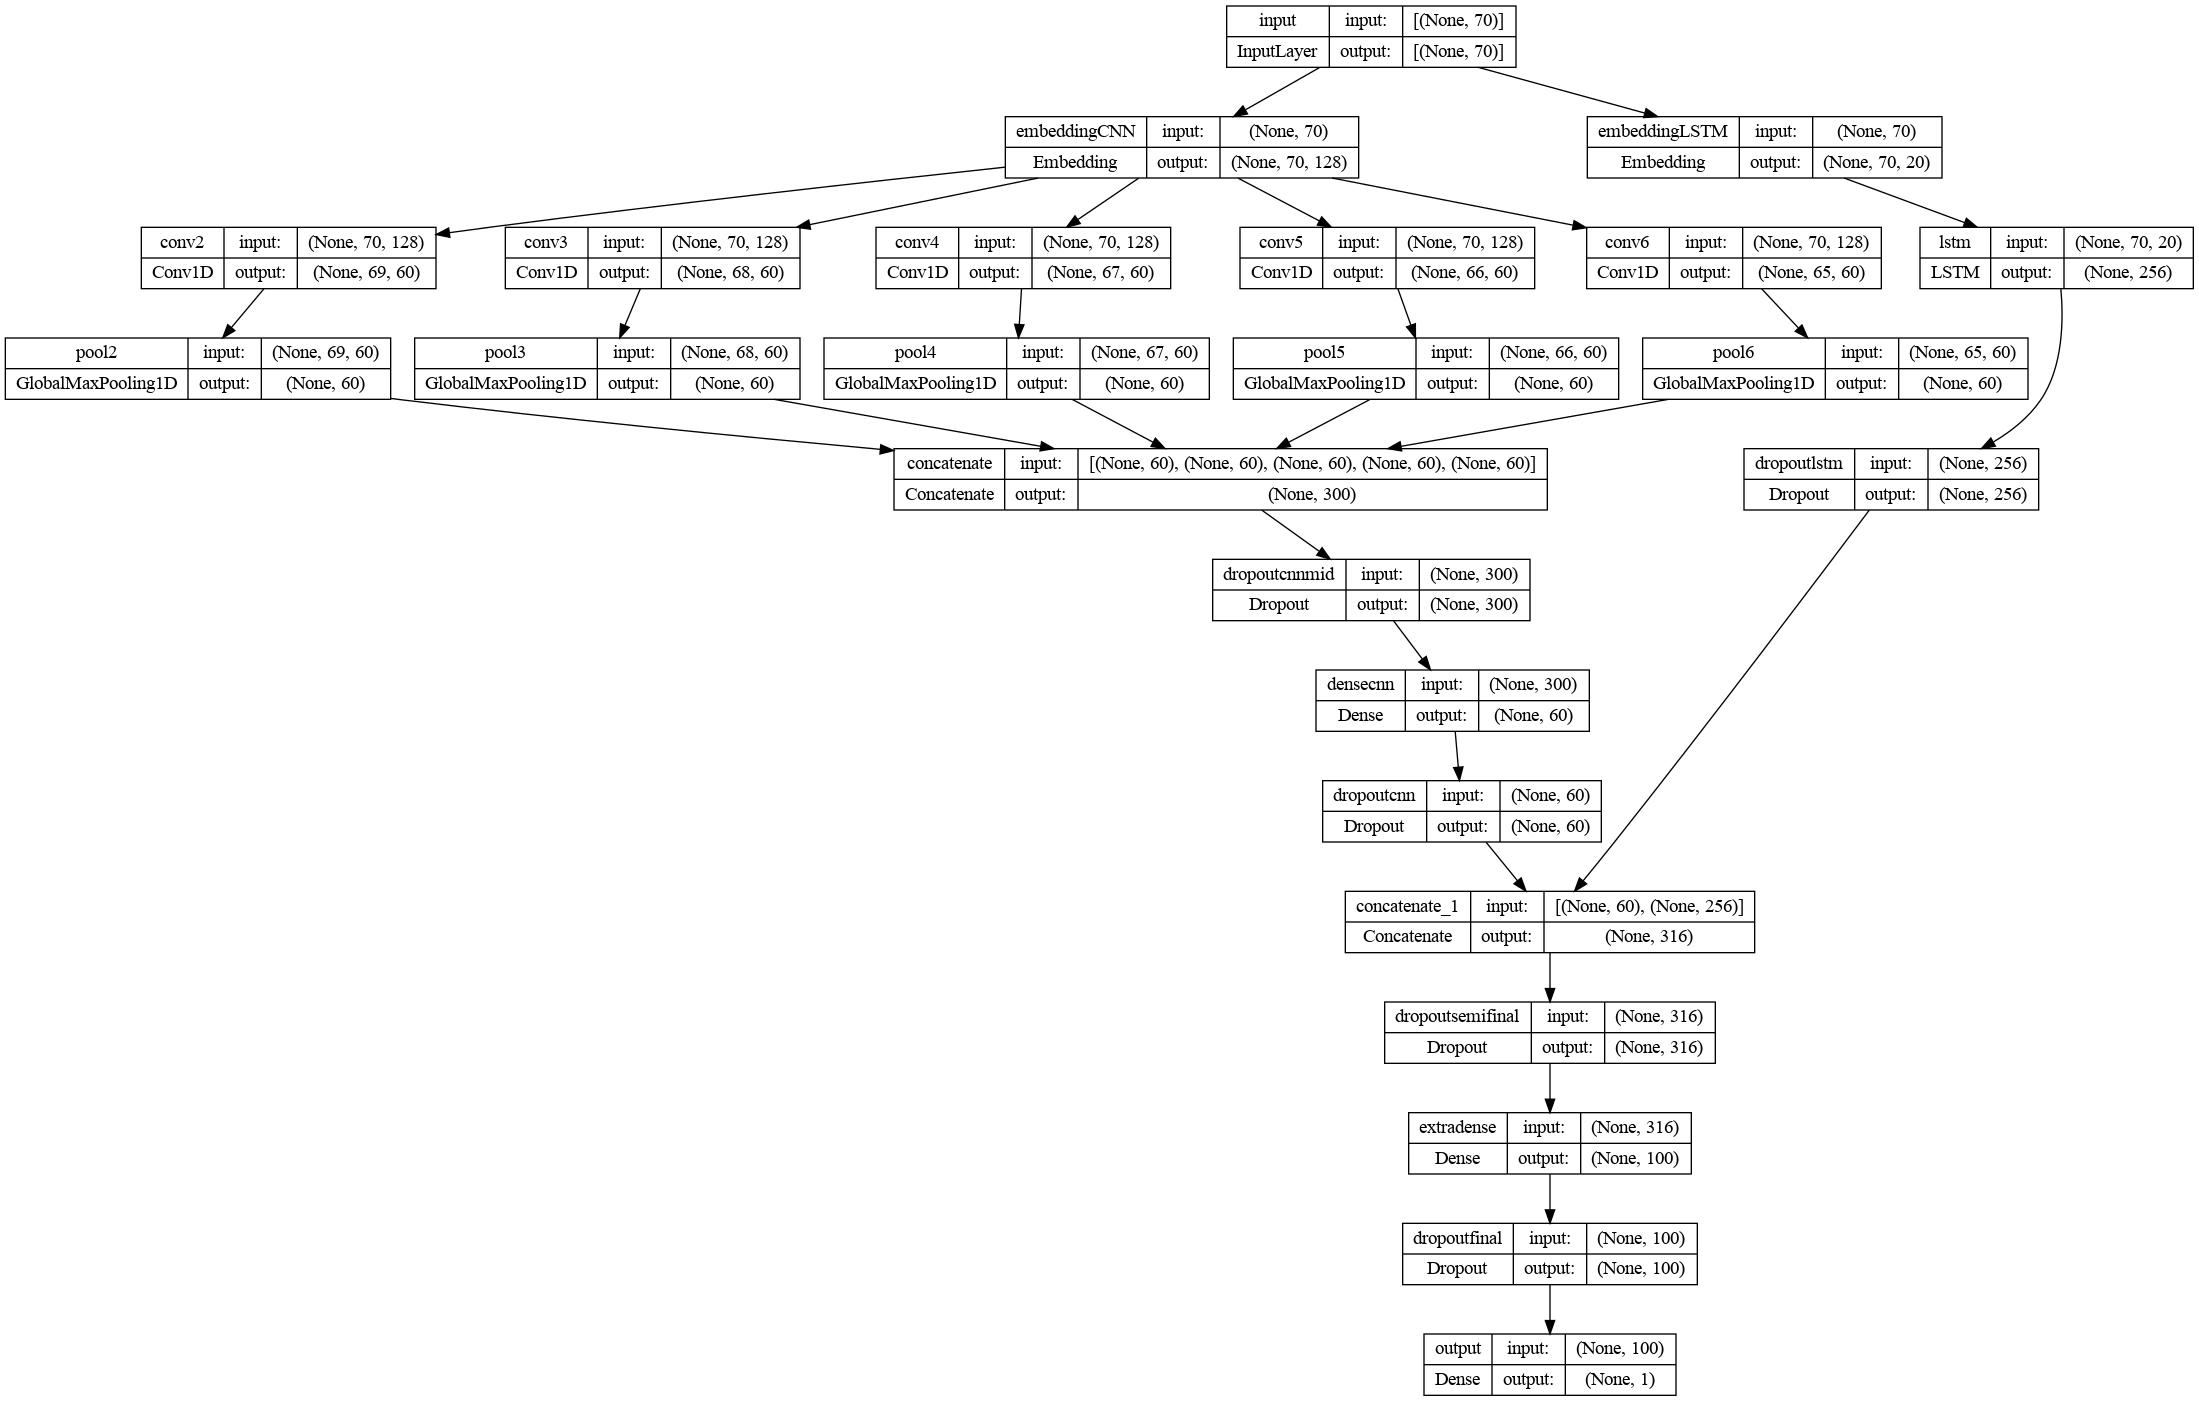

In [16]:
plot_model(model_bilbo, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [17]:
best_bilbo = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model_bilbo2',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [18]:
model_bilbo.fit(X_train, y_train,
              epochs=10,
              validation_split = 0.1,
              callbacks = [best_bilbo],
              batch_size=200)

Epoch 1/10


2024-04-10 17:28:26.784830: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8902
2024-04-10 17:28:27.198949: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-04-10 17:28:27.279435: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.68GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


   4/7410 [..............................] - ETA: 2:12 - loss: 0.6896 - accuracy: 0.5325   

2024-04-10 17:28:27.791127: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.68GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-10 17:28:27.911246: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.68GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


7410/7410 [==============================] - ETA: 0s - loss: 0.3194 - accuracy: 0.8495INFO:tensorflow:Assets written to: best_model_bilbo2/assets


INFO:tensorflow:Assets written to: best_model_bilbo2/assets


7410/7410 [==============================] - 146s 19ms/step - loss: 0.3194 - accuracy: 0.8495 - val_loss: 0.2319 - val_accuracy: 0.9045
Epoch 2/10
7408/7410 [============================>.] - ETA: 0s - loss: 0.2278 - accuracy: 0.9083INFO:tensorflow:Assets written to: best_model_bilbo2/assets


INFO:tensorflow:Assets written to: best_model_bilbo2/assets


7410/7410 [==============================] - 142s 19ms/step - loss: 0.2278 - accuracy: 0.9083 - val_loss: 0.1989 - val_accuracy: 0.9193
Epoch 3/10
7408/7410 [============================>.] - ETA: 0s - loss: 0.1940 - accuracy: 0.9236INFO:tensorflow:Assets written to: best_model_bilbo2/assets


INFO:tensorflow:Assets written to: best_model_bilbo2/assets


7410/7410 [==============================] - 142s 19ms/step - loss: 0.1940 - accuracy: 0.9236 - val_loss: 0.1742 - val_accuracy: 0.9311
Epoch 4/10
7408/7410 [============================>.] - ETA: 0s - loss: 0.1737 - accuracy: 0.9328INFO:tensorflow:Assets written to: best_model_bilbo2/assets


INFO:tensorflow:Assets written to: best_model_bilbo2/assets


7410/7410 [==============================] - 142s 19ms/step - loss: 0.1737 - accuracy: 0.9328 - val_loss: 0.1632 - val_accuracy: 0.9365
Epoch 5/10
7408/7410 [============================>.] - ETA: 0s - loss: 0.1600 - accuracy: 0.9385INFO:tensorflow:Assets written to: best_model_bilbo2/assets


INFO:tensorflow:Assets written to: best_model_bilbo2/assets


7410/7410 [==============================] - 141s 19ms/step - loss: 0.1599 - accuracy: 0.9385 - val_loss: 0.1482 - val_accuracy: 0.9428
Epoch 6/10
7408/7410 [============================>.] - ETA: 0s - loss: 0.1507 - accuracy: 0.9424INFO:tensorflow:Assets written to: best_model_bilbo2/assets


INFO:tensorflow:Assets written to: best_model_bilbo2/assets


7410/7410 [==============================] - 142s 19ms/step - loss: 0.1507 - accuracy: 0.9424 - val_loss: 0.1407 - val_accuracy: 0.9470
Epoch 7/10
7408/7410 [============================>.] - ETA: 0s - loss: 0.1420 - accuracy: 0.9460INFO:tensorflow:Assets written to: best_model_bilbo2/assets


INFO:tensorflow:Assets written to: best_model_bilbo2/assets


7410/7410 [==============================] - 142s 19ms/step - loss: 0.1420 - accuracy: 0.9460 - val_loss: 0.1313 - val_accuracy: 0.9495
Epoch 8/10
7408/7410 [============================>.] - ETA: 0s - loss: 0.1326 - accuracy: 0.9498INFO:tensorflow:Assets written to: best_model_bilbo2/assets


INFO:tensorflow:Assets written to: best_model_bilbo2/assets


7410/7410 [==============================] - 142s 19ms/step - loss: 0.1326 - accuracy: 0.9498 - val_loss: 0.1248 - val_accuracy: 0.9523
Epoch 9/10
7410/7410 [==============================] - 140s 19ms/step - loss: 0.1256 - accuracy: 0.9524 - val_loss: 0.1226 - val_accuracy: 0.9522
Epoch 10/10
7408/7410 [============================>.] - ETA: 0s - loss: 0.1196 - accuracy: 0.9549INFO:tensorflow:Assets written to: best_model_bilbo2/assets


INFO:tensorflow:Assets written to: best_model_bilbo2/assets


7410/7410 [==============================] - 141s 19ms/step - loss: 0.1196 - accuracy: 0.9549 - val_loss: 0.1156 - val_accuracy: 0.9560


In [19]:
model_bilbo = tf.keras.models.load_model('best_model_bilbo2')

In [20]:
predictions = model_bilbo.predict(X_test)
predictions = np.where(predictions > 0.5, 1, 0)

print('Matriz de Confusão')
print(confusion_matrix(y_test,predictions))

print('Relatório de Classificação')
print(classification_report(y_test,predictions, digits=4))

22052/22052 [==============================] - 48s 2ms/step
Matriz de Confusão
[[287131  12542]
 [ 18125 387865]]
Relatório de Classificação
              precision    recall  f1-score   support

           0     0.9406    0.9581    0.9493    299673
           1     0.9687    0.9554    0.9620    405990

    accuracy                         0.9565    705663
   macro avg     0.9547    0.9568    0.9556    705663
weighted avg     0.9568    0.9565    0.9566    705663



## Adversarial CNN+LSTM

In [21]:
hidden_dims=128
nb_filter = 64
filter_length =5 
embedding_vecor_length = 128
pool_length=4
lstm_output_size = 70



model_cnn_lstm = tf.keras.Sequential()
model_cnn_lstm.add(layers.Embedding(256, 60, input_length=70))
model_cnn_lstm.add(layers.Conv1D(filters=nb_filter, kernel_size=filter_length, activation='relu'))
model_cnn_lstm.add(layers.MaxPooling1D(pool_length))
model_cnn_lstm.add(layers.LSTM(lstm_output_size))
model_cnn_lstm.add(layers.Dense(1))
model_cnn_lstm.add(layers.Activation('sigmoid'))

model_cnn_lstm.compile(optimizer = opt, loss = 'binary_crossentropy', metrics='accuracy')
model_cnn_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 70, 60)            15360     
                                                                 
 conv1d (Conv1D)             (None, 66, 64)            19264     
                                                                 
 max_pooling1d (MaxPooling1  (None, 16, 64)            0         
 D)                                                              
                                                                 
 lstm (LSTM)                 (None, 70)                37800     
                                                                 
 dense (Dense)               (None, 1)                 71        
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                        

In [22]:
best_cnn_lstm = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model_cnn_lstm2',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [23]:
model_cnn_lstm.fit(X_train, y_train,
              epochs=10,
              validation_split = 0.1,
              callbacks = [best_cnn_lstm],
              batch_size=200)

Epoch 1/10
7410/7410 [==============================] - ETA: 0s - loss: 0.1494 - accuracy: 0.9421INFO:tensorflow:Assets written to: best_model_cnn_lstm2/assets


INFO:tensorflow:Assets written to: best_model_cnn_lstm2/assets


7410/7410 [==============================] - 30s 4ms/step - loss: 0.1494 - accuracy: 0.9421 - val_loss: 0.1181 - val_accuracy: 0.9554
Epoch 2/10
7398/7410 [============================>.] - ETA: 0s - loss: 0.1096 - accuracy: 0.9586INFO:tensorflow:Assets written to: best_model_cnn_lstm2/assets


INFO:tensorflow:Assets written to: best_model_cnn_lstm2/assets


7410/7410 [==============================] - 31s 4ms/step - loss: 0.1096 - accuracy: 0.9586 - val_loss: 0.1031 - val_accuracy: 0.9615
Epoch 3/10
7410/7410 [==============================] - ETA: 0s - loss: 0.0987 - accuracy: 0.9628INFO:tensorflow:Assets written to: best_model_cnn_lstm2/assets


INFO:tensorflow:Assets written to: best_model_cnn_lstm2/assets


7410/7410 [==============================] - 31s 4ms/step - loss: 0.0987 - accuracy: 0.9628 - val_loss: 0.0960 - val_accuracy: 0.9640
Epoch 4/10
7399/7410 [============================>.] - ETA: 0s - loss: 0.0930 - accuracy: 0.9648INFO:tensorflow:Assets written to: best_model_cnn_lstm2/assets


INFO:tensorflow:Assets written to: best_model_cnn_lstm2/assets


7410/7410 [==============================] - 30s 4ms/step - loss: 0.0930 - accuracy: 0.9648 - val_loss: 0.0916 - val_accuracy: 0.9655
Epoch 5/10
7410/7410 [==============================] - ETA: 0s - loss: 0.0895 - accuracy: 0.9661INFO:tensorflow:Assets written to: best_model_cnn_lstm2/assets


INFO:tensorflow:Assets written to: best_model_cnn_lstm2/assets


7410/7410 [==============================] - 30s 4ms/step - loss: 0.0895 - accuracy: 0.9661 - val_loss: 0.0903 - val_accuracy: 0.9660
Epoch 6/10
7409/7410 [============================>.] - ETA: 0s - loss: 0.0868 - accuracy: 0.9671INFO:tensorflow:Assets written to: best_model_cnn_lstm2/assets


INFO:tensorflow:Assets written to: best_model_cnn_lstm2/assets


7410/7410 [==============================] - 30s 4ms/step - loss: 0.0868 - accuracy: 0.9671 - val_loss: 0.0888 - val_accuracy: 0.9668
Epoch 7/10
7410/7410 [==============================] - ETA: 0s - loss: 0.0846 - accuracy: 0.9681INFO:tensorflow:Assets written to: best_model_cnn_lstm2/assets


INFO:tensorflow:Assets written to: best_model_cnn_lstm2/assets


7410/7410 [==============================] - 29s 4ms/step - loss: 0.0846 - accuracy: 0.9681 - val_loss: 0.0864 - val_accuracy: 0.9677
Epoch 8/10
7409/7410 [============================>.] - ETA: 0s - loss: 0.0828 - accuracy: 0.9687INFO:tensorflow:Assets written to: best_model_cnn_lstm2/assets


INFO:tensorflow:Assets written to: best_model_cnn_lstm2/assets


7410/7410 [==============================] - 31s 4ms/step - loss: 0.0828 - accuracy: 0.9687 - val_loss: 0.0852 - val_accuracy: 0.9683
Epoch 9/10
7410/7410 [==============================] - 31s 4ms/step - loss: 0.0811 - accuracy: 0.9693 - val_loss: 0.0862 - val_accuracy: 0.9675
Epoch 10/10
7403/7410 [============================>.] - ETA: 0s - loss: 0.0796 - accuracy: 0.9700INFO:tensorflow:Assets written to: best_model_cnn_lstm2/assets


INFO:tensorflow:Assets written to: best_model_cnn_lstm2/assets


7410/7410 [==============================] - 29s 4ms/step - loss: 0.0795 - accuracy: 0.9700 - val_loss: 0.0824 - val_accuracy: 0.9690


In [24]:
model_cnn_lstm = tf.keras.models.load_model('best_model_cnn_lstm2')

In [25]:
predictions = model_cnn_lstm.predict(X_test)
predictions = np.where(predictions > 0.5, 1, 0)

print('Matriz de Confusão')
print(confusion_matrix(y_test,predictions))

print('Relatório de Classificação')
print(classification_report(y_test,predictions, digits=4))

22052/22052 [==============================] - 20s 903us/step
Matriz de Confusão
[[288260  11413]
 [ 10314 395676]]
Relatório de Classificação
              precision    recall  f1-score   support

           0     0.9655    0.9619    0.9637    299673
           1     0.9720    0.9746    0.9733    405990

    accuracy                         0.9692    705663
   macro avg     0.9687    0.9683    0.9685    705663
weighted avg     0.9692    0.9692    0.9692    705663



## Adversarial RNN

In [14]:
model_rnn = tf.keras.Sequential()
model_rnn.add(layers.Embedding(256, 60, input_length=70))
model_rnn.add(layers.SimpleRNN(128))
model_rnn.add(layers.Dropout(0.1))
model_rnn.add(layers.Dense(1))
model_rnn.add(layers.Activation('sigmoid'))


model_rnn.compile(optimizer = opt, loss = 'binary_crossentropy', metrics='accuracy')
model_rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 70, 60)            15360     
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               24192     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 39681 (155.00 KB)
Trainable params: 39681 (155.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
best_rnn = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model_rnn2',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [16]:
model_rnn.fit(X_train, y_train,
              epochs=10,
              validation_split = 0.1,
              callbacks = [best_rnn],
              batch_size=200)

Epoch 1/10


2024-04-10 18:06:12.645956: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-04-10 18:06:12.656604: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x79d9700039e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-10 18:06:12.656620: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-04-10 18:06:12.660373: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-10 18:06:12.670359: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8902
2024-04-10 18:06:12.744497: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifeti

7408/7410 [============================>.] - ETA: 0s - loss: 0.2137 - accuracy: 0.9162INFO:tensorflow:Assets written to: best_model_rnn2/assets


INFO:tensorflow:Assets written to: best_model_rnn2/assets


7410/7410 [==============================] - 142s 19ms/step - loss: 0.2137 - accuracy: 0.9162 - val_loss: 0.1720 - val_accuracy: 0.9331
Epoch 2/10
7409/7410 [============================>.] - ETA: 0s - loss: 0.1583 - accuracy: 0.9394INFO:tensorflow:Assets written to: best_model_rnn2/assets


INFO:tensorflow:Assets written to: best_model_rnn2/assets


7410/7410 [==============================] - 137s 19ms/step - loss: 0.1583 - accuracy: 0.9394 - val_loss: 0.1417 - val_accuracy: 0.9460
Epoch 3/10
7408/7410 [============================>.] - ETA: 0s - loss: 0.1402 - accuracy: 0.9469INFO:tensorflow:Assets written to: best_model_rnn2/assets


INFO:tensorflow:Assets written to: best_model_rnn2/assets


7410/7410 [==============================] - 132s 18ms/step - loss: 0.1402 - accuracy: 0.9469 - val_loss: 0.1308 - val_accuracy: 0.9511
Epoch 4/10
7410/7410 [==============================] - 131s 18ms/step - loss: 0.1299 - accuracy: 0.9509 - val_loss: 0.1298 - val_accuracy: 0.9510
Epoch 5/10
7408/7410 [============================>.] - ETA: 0s - loss: 0.1233 - accuracy: 0.9536INFO:tensorflow:Assets written to: best_model_rnn2/assets


INFO:tensorflow:Assets written to: best_model_rnn2/assets


7410/7410 [==============================] - 132s 18ms/step - loss: 0.1233 - accuracy: 0.9537 - val_loss: 0.1242 - val_accuracy: 0.9545
Epoch 6/10
7408/7410 [============================>.] - ETA: 0s - loss: 0.1182 - accuracy: 0.9557INFO:tensorflow:Assets written to: best_model_rnn2/assets


INFO:tensorflow:Assets written to: best_model_rnn2/assets


7410/7410 [==============================] - 132s 18ms/step - loss: 0.1182 - accuracy: 0.9557 - val_loss: 0.1162 - val_accuracy: 0.9562
Epoch 7/10
7407/7410 [============================>.] - ETA: 0s - loss: 0.1145 - accuracy: 0.9572INFO:tensorflow:Assets written to: best_model_rnn2/assets


INFO:tensorflow:Assets written to: best_model_rnn2/assets


7410/7410 [==============================] - 132s 18ms/step - loss: 0.1145 - accuracy: 0.9572 - val_loss: 0.1097 - val_accuracy: 0.9586
Epoch 8/10
7410/7410 [==============================] - 132s 18ms/step - loss: 0.1113 - accuracy: 0.9584 - val_loss: 0.1104 - val_accuracy: 0.9585
Epoch 9/10
7408/7410 [============================>.] - ETA: 0s - loss: 0.1090 - accuracy: 0.9593INFO:tensorflow:Assets written to: best_model_rnn2/assets


INFO:tensorflow:Assets written to: best_model_rnn2/assets


7410/7410 [==============================] - 132s 18ms/step - loss: 0.1090 - accuracy: 0.9593 - val_loss: 0.1097 - val_accuracy: 0.9588
Epoch 10/10
7410/7410 [==============================] - ETA: 0s - loss: 0.1067 - accuracy: 0.9602INFO:tensorflow:Assets written to: best_model_rnn2/assets


INFO:tensorflow:Assets written to: best_model_rnn2/assets


7410/7410 [==============================] - 132s 18ms/step - loss: 0.1067 - accuracy: 0.9602 - val_loss: 0.1053 - val_accuracy: 0.9604


In [17]:
model_rnn = tf.keras.models.load_model('best_model_rnn2')

In [18]:
predictions = model_rnn.predict(X_test)
predictions = np.where(predictions > 0.5, 1, 0)

print('Matriz de Confusão')
print(confusion_matrix(y_test,predictions))

print('Relatório de Classificação')
print(classification_report(y_test,predictions, digits=4))

22052/22052 [==============================] - 87s 4ms/step
Matriz de Confusão
[[286243  13430]
 [ 14073 391917]]
Relatório de Classificação
              precision    recall  f1-score   support

           0     0.9531    0.9552    0.9542    299673
           1     0.9669    0.9653    0.9661    405990

    accuracy                         0.9610    705663
   macro avg     0.9600    0.9603    0.9601    705663
weighted avg     0.9610    0.9610    0.9610    705663



## Adversarial CNN

In [19]:
#Carregando hyperparâmetros de regularizadores, otimizador e função de ativação
l1l2 = keras.regularizers.l1_l2(l1=0.00001, l2=0.0001)
opt = keras.optimizers.legacy.Adam(learning_rate=0.0001)
fx = "relu"

hidden_dims=128
nb_filter = 64
filter_length =5 
embedding_vecor_length = 128
pool_length=4
lstm_output_size = 70

model_cnn = tf.keras.Sequential()
model_cnn.add(layers.Embedding(256, 60, input_length=70))
model_cnn.add(layers.Conv1D(filters=nb_filter, kernel_size=filter_length, activation='relu'))
model_cnn.add(layers.GlobalMaxPooling1D())
model_cnn.add(layers.Dense(hidden_dims))
model_cnn.add(layers.Dropout(0.2))
model_cnn.add(layers.Activation('relu'))
model_cnn.add(layers.Dense(1))
model_cnn.add(layers.Activation('sigmoid'))

model_cnn.compile(optimizer = opt, loss = 'binary_crossentropy', metrics='accuracy')
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 70, 60)            15360     
                                                                 
 conv1d (Conv1D)             (None, 66, 64)            19264     
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 activation_1 (Activation)   (None, 128)               0         
                                                      

In [20]:
best_cnn = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model_cnn2',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [21]:
model_cnn.fit(X_train, y_train,
              epochs=10,
              validation_split = 0.1,
              callbacks = [best_cnn],
              batch_size=200)

Epoch 1/10
7410/7410 [==============================] - ETA: 0s - loss: 0.2176 - accuracy: 0.9103INFO:tensorflow:Assets written to: best_model_cnn2/assets


INFO:tensorflow:Assets written to: best_model_cnn2/assets


7410/7410 [==============================] - 18s 2ms/step - loss: 0.2176 - accuracy: 0.9103 - val_loss: 0.1539 - val_accuracy: 0.9385
Epoch 2/10
7391/7410 [============================>.] - ETA: 0s - loss: 0.1399 - accuracy: 0.9443INFO:tensorflow:Assets written to: best_model_cnn2/assets


INFO:tensorflow:Assets written to: best_model_cnn2/assets


7410/7410 [==============================] - 17s 2ms/step - loss: 0.1399 - accuracy: 0.9443 - val_loss: 0.1314 - val_accuracy: 0.9470
Epoch 3/10
7400/7410 [============================>.] - ETA: 0s - loss: 0.1235 - accuracy: 0.9508INFO:tensorflow:Assets written to: best_model_cnn2/assets


INFO:tensorflow:Assets written to: best_model_cnn2/assets


7410/7410 [==============================] - 17s 2ms/step - loss: 0.1235 - accuracy: 0.9508 - val_loss: 0.1193 - val_accuracy: 0.9521
Epoch 4/10
7407/7410 [============================>.] - ETA: 0s - loss: 0.1148 - accuracy: 0.9543INFO:tensorflow:Assets written to: best_model_cnn2/assets


INFO:tensorflow:Assets written to: best_model_cnn2/assets


7410/7410 [==============================] - 17s 2ms/step - loss: 0.1148 - accuracy: 0.9543 - val_loss: 0.1130 - val_accuracy: 0.9551
Epoch 5/10
7401/7410 [============================>.] - ETA: 0s - loss: 0.1092 - accuracy: 0.9568INFO:tensorflow:Assets written to: best_model_cnn2/assets


INFO:tensorflow:Assets written to: best_model_cnn2/assets


7410/7410 [==============================] - 17s 2ms/step - loss: 0.1092 - accuracy: 0.9568 - val_loss: 0.1089 - val_accuracy: 0.9564
Epoch 6/10
7396/7410 [============================>.] - ETA: 0s - loss: 0.1052 - accuracy: 0.9583INFO:tensorflow:Assets written to: best_model_cnn2/assets


INFO:tensorflow:Assets written to: best_model_cnn2/assets


7410/7410 [==============================] - 17s 2ms/step - loss: 0.1052 - accuracy: 0.9583 - val_loss: 0.1056 - val_accuracy: 0.9579
Epoch 7/10
7390/7410 [============================>.] - ETA: 0s - loss: 0.1020 - accuracy: 0.9595INFO:tensorflow:Assets written to: best_model_cnn2/assets


INFO:tensorflow:Assets written to: best_model_cnn2/assets


7410/7410 [==============================] - 17s 2ms/step - loss: 0.1021 - accuracy: 0.9595 - val_loss: 0.1035 - val_accuracy: 0.9590
Epoch 8/10
7405/7410 [============================>.] - ETA: 0s - loss: 0.0995 - accuracy: 0.9608INFO:tensorflow:Assets written to: best_model_cnn2/assets


INFO:tensorflow:Assets written to: best_model_cnn2/assets


7410/7410 [==============================] - 17s 2ms/step - loss: 0.0995 - accuracy: 0.9608 - val_loss: 0.1008 - val_accuracy: 0.9601
Epoch 9/10
7400/7410 [============================>.] - ETA: 0s - loss: 0.0973 - accuracy: 0.9616INFO:tensorflow:Assets written to: best_model_cnn2/assets


INFO:tensorflow:Assets written to: best_model_cnn2/assets


7410/7410 [==============================] - 17s 2ms/step - loss: 0.0973 - accuracy: 0.9616 - val_loss: 0.1004 - val_accuracy: 0.9604
Epoch 10/10
7410/7410 [==============================] - 17s 2ms/step - loss: 0.0954 - accuracy: 0.9625 - val_loss: 0.0999 - val_accuracy: 0.9604


In [22]:
model_cnn = tf.keras.models.load_model('best_model_cnn2')

In [23]:
predictions = model_cnn.predict(X_test)
predictions = np.where(predictions > 0.5, 1, 0)

print('Matriz de Confusão')
print(confusion_matrix(y_test,predictions))

print('Relatório de Classificação')
print(classification_report(y_test,predictions, digits=4))

22052/22052 [==============================] - 13s 574us/step
Matriz de Confusão
[[283956  15717]
 [ 11939 394051]]
Relatório de Classificação
              precision    recall  f1-score   support

           0     0.9597    0.9476    0.9536    299673
           1     0.9616    0.9706    0.9661    405990

    accuracy                         0.9608    705663
   macro avg     0.9606    0.9591    0.9598    705663
weighted avg     0.9608    0.9608    0.9608    705663



## DistilBERT Tokenizer + DNN

In [10]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2024-04-13 14:35:18.702809: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-13 14:35:18.748404: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-13 14:35:18.748556: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [11]:
df_test = df_test.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)

In [12]:
import transformers
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [13]:
X_train = df_train['domain']
y_train = df_train['label']
y_train = y_train.to_numpy()

In [14]:
X_test = df_test['domain']
y_test = df_test['label']
y_test = y_test.to_numpy()

In [15]:
X_train_tk = [tokenizer(text, padding='max_length', max_length = 10, truncation=True)['input_ids'] for text in X_train]
X_train_tk = np.array(X_train_tk, dtype='int32')

In [16]:
X_test_tk = [tokenizer(text, padding='max_length', max_length = 10, truncation=True)['input_ids'] for text in X_test]
X_test_tk = np.array(X_test_tk, dtype='int32')

In [17]:
config = transformers.DistilBertConfig(dropout=0.2, attention_dropout=0.2)
dbert_tf = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased', config=config, trainable=False)

2024-04-13 14:40:19.545722: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-13 14:40:19.546217: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-13 14:40:19.546571: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [18]:
X_test_tk[2]

array([  101,  1061, 17822,  2595, 22269, 23223,  3683,  1012, 21766,
         102], dtype=int32)

In [19]:
input_ids_in = layers.Input(shape=(10,), name='input_token', dtype='int32')

x = dbert_tf(input_ids=input_ids_in)[0][:,0,:]
x = layers.Dropout(0.2, name='dropout')(x)
x = layers.Dense(64, activation='relu', name='dense')(x)
x = layers.Dense(1, activation='sigmoid', name='classification')(x)

model_bert = tf.keras.Model(inputs=input_ids_in, outputs = x, name='ClassificationModelTF')

model_bert.compile(optimizer='adam',loss='binary_crossentropy', metrics='accuracy')
model_bert.summary()

Model: "ClassificationModelTF"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_token (InputLayer)    [(None, 10)]              0         
                                                                 
 tf_distil_bert_model (TFDi  TFBaseModelOutput(last_   66362880  
 stilBertModel)              hidden_state=(None, 10,             
                              768),                              
                              hidden_states=None, at             
                             tentions=None)                      
                                                                 
 tf.__operators__.getitem (  (None, 768)               0         
 SlicingOpLambda)                                                
                                                                 
 dropout (Dropout)           (None, 768)               0         
                                             

In [20]:
best_bert = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model_bert2',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [21]:
model_bert.fit(X_train_tk, y_train,
              epochs=10,
              validation_split = 0.1,
              callbacks = [best_bert],
              batch_size=200)

Epoch 1/10


2024-04-13 14:40:26.474594: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5ed4f4d26c50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-13 14:40:26.474611: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-04-13 14:40:26.479007: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-13 14:40:26.488468: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8902
2024-04-13 14:40:26.568096: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


7409/7410 [============================>.] - ETA: 0s - loss: 0.2347 - accuracy: 0.8987WARNING:tensorflow:Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x79cbda1347f0>, because it is not built.
INFO:tensorflow:Assets written to: best_model_bert2/assets


INFO:tensorflow:Assets written to: best_model_bert2/assets


7410/7410 [==============================] - 522s 70ms/step - loss: 0.2347 - accuracy: 0.8987 - val_loss: 0.1692 - val_accuracy: 0.9331
Epoch 2/10
7409/7410 [============================>.] - ETA: 0s - loss: 0.2087 - accuracy: 0.9108WARNING:tensorflow:Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x79cbda1347f0>, because it is not built.


INFO:tensorflow:Assets written to: best_model_bert2/assets


INFO:tensorflow:Assets written to: best_model_bert2/assets


7410/7410 [==============================] - 519s 70ms/step - loss: 0.2087 - accuracy: 0.9108 - val_loss: 0.1614 - val_accuracy: 0.9361
Epoch 3/10
7409/7410 [============================>.] - ETA: 0s - loss: 0.2012 - accuracy: 0.9142WARNING:tensorflow:Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x79cbda1347f0>, because it is not built.


INFO:tensorflow:Assets written to: best_model_bert2/assets


INFO:tensorflow:Assets written to: best_model_bert2/assets


7410/7410 [==============================] - 523s 71ms/step - loss: 0.2012 - accuracy: 0.9142 - val_loss: 0.1508 - val_accuracy: 0.9395
Epoch 4/10
7409/7410 [============================>.] - ETA: 0s - loss: 0.1969 - accuracy: 0.9162WARNING:tensorflow:Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x79cbda1347f0>, because it is not built.


INFO:tensorflow:Assets written to: best_model_bert2/assets


INFO:tensorflow:Assets written to: best_model_bert2/assets


7410/7410 [==============================] - 525s 71ms/step - loss: 0.1969 - accuracy: 0.9162 - val_loss: 0.1497 - val_accuracy: 0.9408
Epoch 5/10
7409/7410 [============================>.] - ETA: 0s - loss: 0.1937 - accuracy: 0.9176WARNING:tensorflow:Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x79cbda1347f0>, because it is not built.


INFO:tensorflow:Assets written to: best_model_bert2/assets


INFO:tensorflow:Assets written to: best_model_bert2/assets


7410/7410 [==============================] - 524s 71ms/step - loss: 0.1937 - accuracy: 0.9176 - val_loss: 0.1450 - val_accuracy: 0.9428
Epoch 6/10
7409/7410 [============================>.] - ETA: 0s - loss: 0.1919 - accuracy: 0.9182WARNING:tensorflow:Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x79cbda1347f0>, because it is not built.


INFO:tensorflow:Assets written to: best_model_bert2/assets


INFO:tensorflow:Assets written to: best_model_bert2/assets


7410/7410 [==============================] - 525s 71ms/step - loss: 0.1919 - accuracy: 0.9182 - val_loss: 0.1437 - val_accuracy: 0.9431
Epoch 7/10
7410/7410 [==============================] - 514s 69ms/step - loss: 0.1906 - accuracy: 0.9189 - val_loss: 0.1430 - val_accuracy: 0.9429
Epoch 8/10
7410/7410 [==============================] - 514s 69ms/step - loss: 0.1895 - accuracy: 0.9190 - val_loss: 0.1412 - val_accuracy: 0.9430
Epoch 9/10
7410/7410 [==============================] - 514s 69ms/step - loss: 0.1885 - accuracy: 0.9196 - val_loss: 0.1413 - val_accuracy: 0.9426
Epoch 10/10
7409/7410 [============================>.] - ETA: 0s - loss: 0.1873 - accuracy: 0.9201WARNING:tensorflow:Skipping full serialization of Keras layer <keras.src.layers.regularization.dropout.Dropout object at 0x79cbda1347f0>, because it is not built.


INFO:tensorflow:Assets written to: best_model_bert2/assets


INFO:tensorflow:Assets written to: best_model_bert2/assets


7410/7410 [==============================] - 525s 71ms/step - loss: 0.1873 - accuracy: 0.9201 - val_loss: 0.1417 - val_accuracy: 0.9436


In [22]:
predictions = model_bert.predict(X_test_tk)
predictions = np.where(predictions > 0.5, 1, 0)

print('Matriz de Confusão')
print(confusion_matrix(y_test,predictions))

print('Relatório de Classificação')
print(classification_report(y_test,predictions, digits=4))

22052/22052 [==============================] - 381s 17ms/step
Matriz de Confusão
[[278478  21195]
 [ 17714 388276]]
Relatório de Classificação
              precision    recall  f1-score   support

           0     0.9402    0.9293    0.9347    299673
           1     0.9482    0.9564    0.9523    405990

    accuracy                         0.9449    705663
   macro avg     0.9442    0.9428    0.9435    705663
weighted avg     0.9448    0.9449    0.9448    705663



In [23]:
model_bert.save_weights('best_model_bert2_weights')